In [49]:
from datasets import load_dataset
import numpy as np

In [50]:
dataset = load_dataset("Rtian/DebugBench")

In [51]:
import difflib

def remove_blank_lines(text):
    return "\n".join([s for s in text.splitlines() if s])

def find_changed_lines(file1_contents, file2_contents):
    diff = difflib.ndiff(file1_contents.splitlines(), file2_contents.splitlines())
    
    changed_lines = []

    current_line_number = 1
    for line in diff:        
        if line.startswith('  '):
            current_line_number += 1
            continue
        elif line.startswith('- '):  # Lines in file1 but not in file2
            changed_lines.append(current_line_number)
            current_line_number += 1        
    return changed_lines

In [52]:
import subprocess
import autopep8

def format_cpp_code(code):
    try:
        process = subprocess.Popen(['clang-format', '--style=file:./clang-format.txt'], 
                                   stdin=subprocess.PIPE, 
                                   stdout=subprocess.PIPE, 
                                   stderr=subprocess.PIPE)
        formatted_code, errors = process.communicate(input=code.encode())
        
        if process.returncode != 0:
            print("Error formatting code: ", errors.decode())
            return code
        
        return formatted_code.decode()
    except Exception as e:
        print(f"An exception occurred: {e}")
        return code
    
def format_python_code(code):
    try:
        return autopep8.fix_code(code)
    except Exception as e:
        print(f"An exception occurred: {e}")
        return code

def format_java_code(code):
    try:
        process = subprocess.Popen(['clang-format', '--style=file:./clang-format.txt', '--assume-filename=Main.java'], 
                                   stdin=subprocess.PIPE, 
                                   stdout=subprocess.PIPE, 
                                   stderr=subprocess.PIPE)
        formatted_code, errors = process.communicate(input=code.encode())
        
        if process.returncode != 0:
            print("Error formatting code: ", errors.decode())
            return code
        
        return formatted_code.decode()
    except Exception as e:
        print(f"An exception occurred: {e}")
        return code

def format_code(code, language):
    if language == "python3":
        return format_python_code(code)
    elif language == "cpp":
        return format_cpp_code(code)
    elif language == "java":
        return format_java_code(code)
    else:
        print(f"Unsupported language: {language}")
        return code

In [71]:
import requests as req
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

def process_entry(entry):
    buggy_code = format_code(remove_blank_lines(entry['buggy_code']), entry['language'])
    solution = format_code(remove_blank_lines(entry['solution']), entry['language'])
    #buggy_code = entry['buggy_code']
    #solution = entry['solution']
    num_lines = buggy_code.count('\n')
    changed_lines = find_changed_lines(buggy_code, solution)
    if len(changed_lines)/ num_lines > 1:
        print(len(changed_lines))
        print(num_lines)
        print(entry)
        print("-----")
        print(buggy_code)
        print("-----")
        print(solution)
        print("-----")


    data = {"code": buggy_code, "language": entry['language']}
    success = True
    response_json = []
    try:
        resp = req.post("http://delos.eaalab.hpi.uni-potsdam.de:8010/highlight-code/", json=data)
        try:
            response_json = resp.json()
            print(response_json)
        except:
            print("Json parsing failed")
            print(resp.text())
    except:
        print("Request failed")
        success = False

    

    predicted_lines = []
    suggestions = []
    descriptions = []
    for item in response_json:
        line_number = int(item['line_number'])
        suggestions.append(item["description"])
        descriptions.append(item["suggestion"])
        predicted_lines.append(line_number)

    return {
        'buggy_code': buggy_code,
        'solution': solution,
        'changed_lines': changed_lines,
        'predicted_lines': predicted_lines,
        'num_lines': num_lines,
        'success': success,
        'suggestions': suggestions,
        'descriptions': descriptions
    }

df = pd.DataFrame(dataset['test'])

matchString = "def findKthLargest\(self, nums: List\[int\], k: int\) -> int:\n( )*return sorted\(no_nums\)\[-k-1\]"
## find the index where buggy code matches partially with the matchString
#index = df[df['buggy_code'].str.contains(matchString)].index
#print(index)

num_rows = len(df)
filtered_df = df.tail(num_rows - 3000)

filtered_df = df#df[df['category'] != 'syntax error']


filtered_df = filtered_df

print("Total number of examples: ", len(filtered_df))

#results = filtered_df.progress_apply(process_entry, axis=1)

Int64Index([3254, 3276, 3550, 3780, 3865], dtype='int64')
Total number of examples:  4253


/tmp/ipykernel_315/3945634689.py:65: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  index = df[df['buggy_code'].str.contains(matchString)].index


In [22]:
df = pd.DataFrame(results.tolist())
df.to_csv("results.csv", index=False)

In [43]:
success_df = df[df["success"]]
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
# We need the following line when working with success_df instead of df
#pd.options.mode.copy_on_write = False
print(f'Number of successful requests: {len(success_df)}')

Number of successful requests: 10


In [44]:
def create_labels(row):
    labels = pd.Series([0] * row['num_lines'])
    for line in row['changed_lines']:
        labels[line - 1] = 1
    assert len(labels) == row['num_lines']
    return labels.tolist()

def create_predictions(row):
    predictions = pd.Series([0] * row['num_lines'])
    for line in row['predicted_lines']:
        if line == -1:
            continue
        if line >= row['num_lines']:
            print(f"Error {line} exceeds {row['num_lines']}")
        predictions[line - 1] = 1
    assert len(predictions) == row['num_lines']
    return predictions.tolist()

df['labels'] = df.apply(create_labels, axis=1)
df['predictions'] = df.apply(create_predictions, axis=1)

labels = np.array([b for a in df['labels'].values for b in a])
predictions = np.array([b for a in df['predictions'].values for b in a])
assert len(labels) == len(predictions)

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score

accuracy = accuracy_score(labels, predictions)
balanced_acc = balanced_accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)
conf_matrix = confusion_matrix(labels, predictions)


print(f'Accuracy: {accuracy}')
print(f'Balanced Accuracy: {balanced_acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

NameError: name 'labels' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8
Area 0.8333333333333333


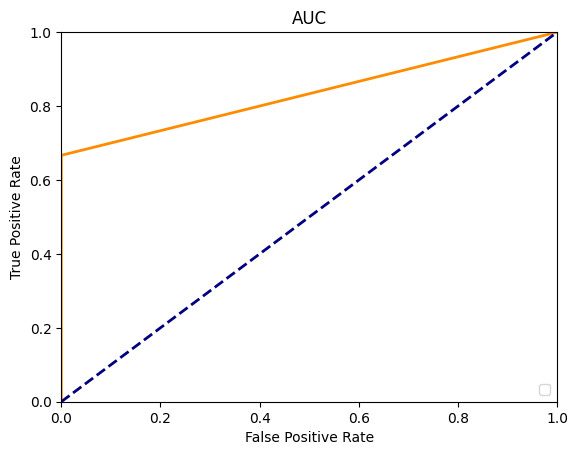

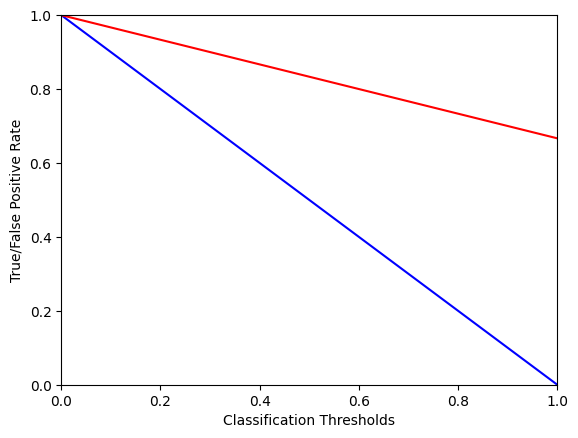

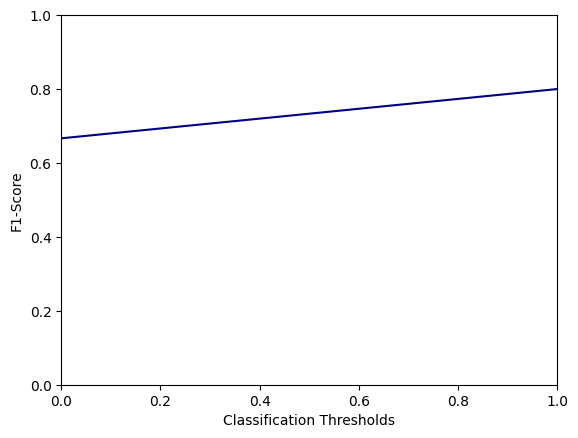

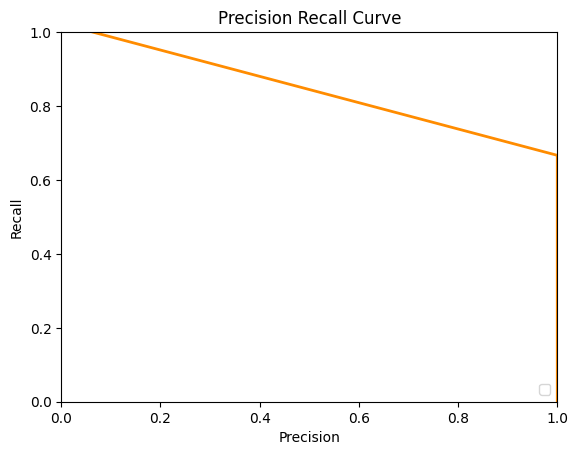

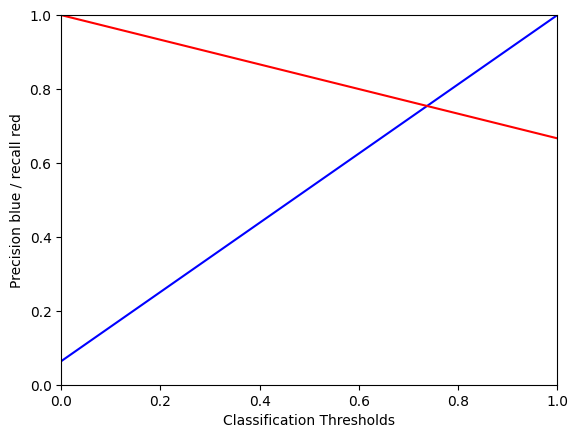

In [9]:
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, precision_recall_curve

num_positives = labels.sum()

fpr, tpr, thresholds = roc_curve(labels, predictions)
precision, recall, thresholds2 = precision_recall_curve(labels, predictions)
fn = [(num_positives) - tp * num_positives for tp in tpr]
f1 = [(2*tpr[i]*num_positives)/(2*tpr[i]*num_positives + fpr[i]*num_positives + fn[i]) for i in range(len(fpr))]
print(max(f1))

roc_auc = auc(fpr, tpr)
print("Area", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC')
plt.legend(loc='lower right')

plt.figure()
plt.plot(thresholds, fpr, color='blue')
plt.plot(thresholds, tpr, color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('True/False Positive Rate')

plt.figure()
plt.plot(thresholds, f1, color='navy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('F1-Score')

plt.figure()
plt.plot(precision, recall, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve')
plt.legend(loc='lower right')

length = min(len(precision), len(recall))
plt.figure()
plt.plot(thresholds2, precision[:length-1], color='blue')
plt.plot(thresholds2, recall[:length-1], color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('Precision blue / recall red')

plt.show()